# ☀️ Renewable Power Generation Prediction - Modelling

## Problem Statement
How weather directly impacts renewable energy generation. That's why we'll approach this problem as a regression problem but not as a time series problem.

# 📚 1. Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import warnings
warnings.simplefilter(action="ignore", category=Warning) # Ignore warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
# Data Processing Librariies
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Ensemble Algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Non-linear Algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

# 📖 2. Load Data

In [3]:
raw_data = pd.read_csv('./Data/Processed/df_non_zero.csv')
print(f'The dataset has {raw_data.shape[0]} rows and {raw_data.shape[1]} columns')

The dataset has 95926 rows and 12 columns


In [4]:
# Creating a copy of the dataframe in case we need the raw data in the next sections
df = raw_data.copy()

## 2.1. Data Overview

In [5]:
df.head()

,Energy_Delta,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,SunlightTime/daylength,weather_type,hour,month
0,5,3.500,1016,99,6.000,0.000,0.000,98,0.130,4,8,1
1,33,3.500,1016,99,6.000,0.000,0.000,98,0.170,4,8,1
2,44,3.500,1016,99,6.000,0.000,0.000,98,0.200,4,8,1
3,61,3.500,1016,99,6.000,0.000,0.000,98,0.230,4,8,1
4,65,3.600,1016,97,6.200,0.000,0.000,100,0.270,4,9,1


In [6]:
df.tail()

,Energy_Delta,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,SunlightTime/daylength,weather_type,hour,month
95921,157,18.600,1023,57,3.800,0.000,0.000,52,0.930,3,16,8
95922,118,18.600,1023,57,3.800,0.000,0.000,52,0.950,3,16,8
95923,82,18.500,1023,61,4.200,0.000,0.000,60,0.960,3,17,8
95924,51,18.500,1023,61,4.200,0.000,0.000,60,0.980,3,17,8
95925,24,18.500,1023,61,4.200,0.000,0.000,60,1.000,3,17,8


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95926 entries, 0 to 95925
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Energy_Delta            95926 non-null  int64  
 1   temp                    95926 non-null  float64
 2   pressure                95926 non-null  int64  
 3   humidity                95926 non-null  int64  
 4   wind_speed              95926 non-null  float64
 5   rain_1h                 95926 non-null  float64
 6   snow_1h                 95926 non-null  float64
 7   clouds_all              95926 non-null  int64  
 8   SunlightTime/daylength  95926 non-null  float64
 9   weather_type            95926 non-null  int64  
 10  hour                    95926 non-null  int64  
 11  month                   95926 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 8.8 MB


🔎 **Observations:**

# 🧹 3. Data Preparation

As we cleaned and prepare the dataset in the EDA notebook, we'll encode the categorical columns and standardize the numeric columns.

In [9]:
df['weather_type'] = df['weather_type'].astype('object')
df['hour'] = df['hour'].astype('object')
df['month'] = df['month'].astype('object')

In [10]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)
        
print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 3 ['weather_type', 'hour', 'month']
Numeric columns: 9 ['Energy_Delta', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'SunlightTime/daylength']


In [11]:
target = num_cols[0]
target

'Energy_Delta'

## 3.1. Transform Dataset

In [12]:
def transform_data(df, target, num_features, cat_features):

    # Assign features and labels
    x = df.drop([target], axis=1)
    y = df[target]
    
    # Split the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    # Standardization and Encoding
    # Define transformers for different column types
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    # Combine transformers for specific columns
    preprocessor = ColumnTransformer([
        ("num", numerical_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ])

    # Fit transformers on training data only
    preprocessor.fit(x_train)

    # Transform train and test data using fitted transformers
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)
    
    return x_train_transformed, x_test_transformed, y_train, y_test

In [15]:
x_train, x_test, y_train, y_test = transform_data(df, target, num_cols[1:], cat_cols)
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (76740, 40)
x_test: (19186, 40)


# 🧱 4. Model Building

## 4.1. Comparing Different Algorithms
In this section we'll compare non-linear and ensemble algorithms using k-fold cross validation and then decide on the candidate algorith for hyperparameter tunin based on the $R^2$ metric.

In [16]:
def model_comparison(x, y, models):
    names = []
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

    df_results = pd.DataFrame(columns=['Algorithm', 'R2 Mean', 'R2 STD', 'RMSE Mean', 'RMSE STD'])
    results_r2 = []
    results_mae = []
    results_rmse = []
    
    for name, model in models:
        names.append(name)
        kfold = KFold(n_splits=10, shuffle=True, random_state=101)
        result = cross_validate(model, x, y, cv=kfold, scoring=scoring)
    
        # R2 Score of the model
        r2_mean = result['test_r2'].mean()
        r2_std = result['test_r2'].std()

        # MAE Score of the model
        mae_mean = abs(result['test_neg_mean_absolute_error'].mean())
        mae_std = result['test_neg_mean_absolute_error'].std()
        
        # RMSE Score of the model
        rmse_mean = abs(result['test_neg_root_mean_squared_error'].mean())
        rmse_std = result['test_neg_root_mean_squared_error'].std()
        

        df_result_row = {'Algorithm': name, 'R2 Mean': r2_mean, 'R2 STD': r2_std, 'RMSE Mean': rmse_mean, 
                         'RMSE STD': rmse_std, 'MAE Mean': mae_mean, 'MEA STD': mae_std}
        df_results = pd.concat([df_results, pd.DataFrame([df_result_row])], ignore_index=True)
        results_r2.append(result['test_r2'])
        results_mae.append(abs(result['test_neg_mean_absolute_error']))
        results_rmse.append(abs(result['test_neg_root_mean_squared_error']))

    df_results = df_results.set_index('Algorithm')
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    # Display the mean and standard deviation of all metrics for all algorithms
    print(df_results)
    
    # Display the overall results in a boxplot graph
    plot_objects = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig, (ax1, ax2, ax3) = plot_objects
    
    ax1.boxplot(results_r2)
    ax1.set_title('R2', fontsize=14)
    ax1.set_xticklabels(names, rotation=30)
    ax2.boxplot(results_mae)
    ax2.set_title('MAE', fontsize=14)
    ax2.set_xticklabels(names, rotation=30)
    ax3.boxplot(results_rmse)
    ax3.set_title('RMSE', fontsize=14)
    ax3.set_xticklabels(names, rotation=30)
    plt.tight_layout()
    plt.show()

### 4.1.1. Ensemble Methods

In [17]:
models_ens = []
models_ens.append(('RFR', RandomForestRegressor()))
models_ens.append(('ADR', AdaBoostRegressor()))
models_ens.append(('GBR', GradientBoostingRegressor()))

           R2 Mean  R2 STD  RMSE Mean  RMSE STD  MAE Mean  MEA STD
Algorithm                                                         
RFR          0.883   0.005    423.699     7.126   254.575    3.784
ADR          0.605   0.012    778.744     8.630   629.324   13.290
GBR          0.757   0.008    610.843     5.595   416.833    3.990


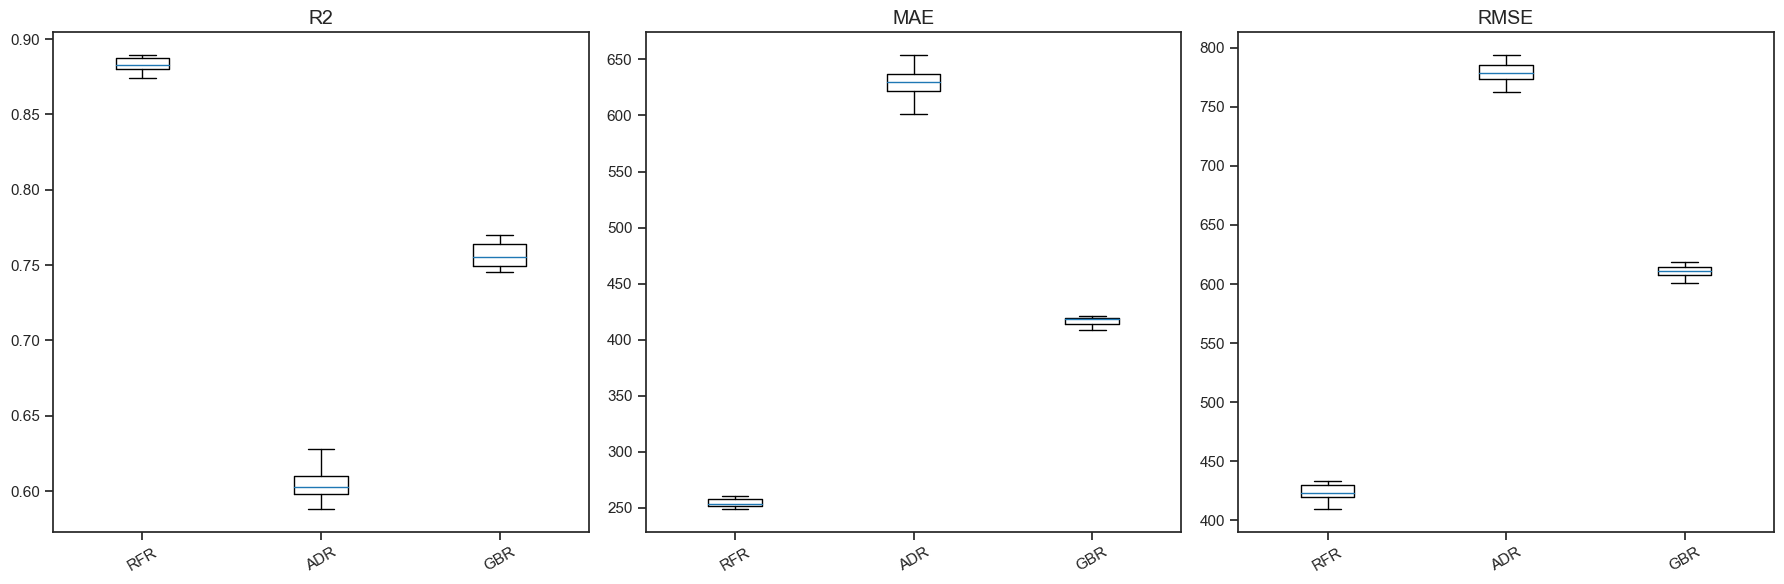

In [18]:
model_comparison(x_train, y_train, models_ens)

### 4.1.2. Non-linear Methods

           R2 Mean  R2 STD  RMSE Mean  RMSE STD  MAE Mean  MEA STD
Algorithm                                                         
DTR          0.796   0.007    559.731    10.254   313.449    5.957
KNN          0.803   0.008    549.204     8.949   342.153    5.166
GNB         -0.689   0.065   1609.911    23.697  1229.115   20.071
XBR          0.824   0.006    519.355     6.001   336.377    3.702


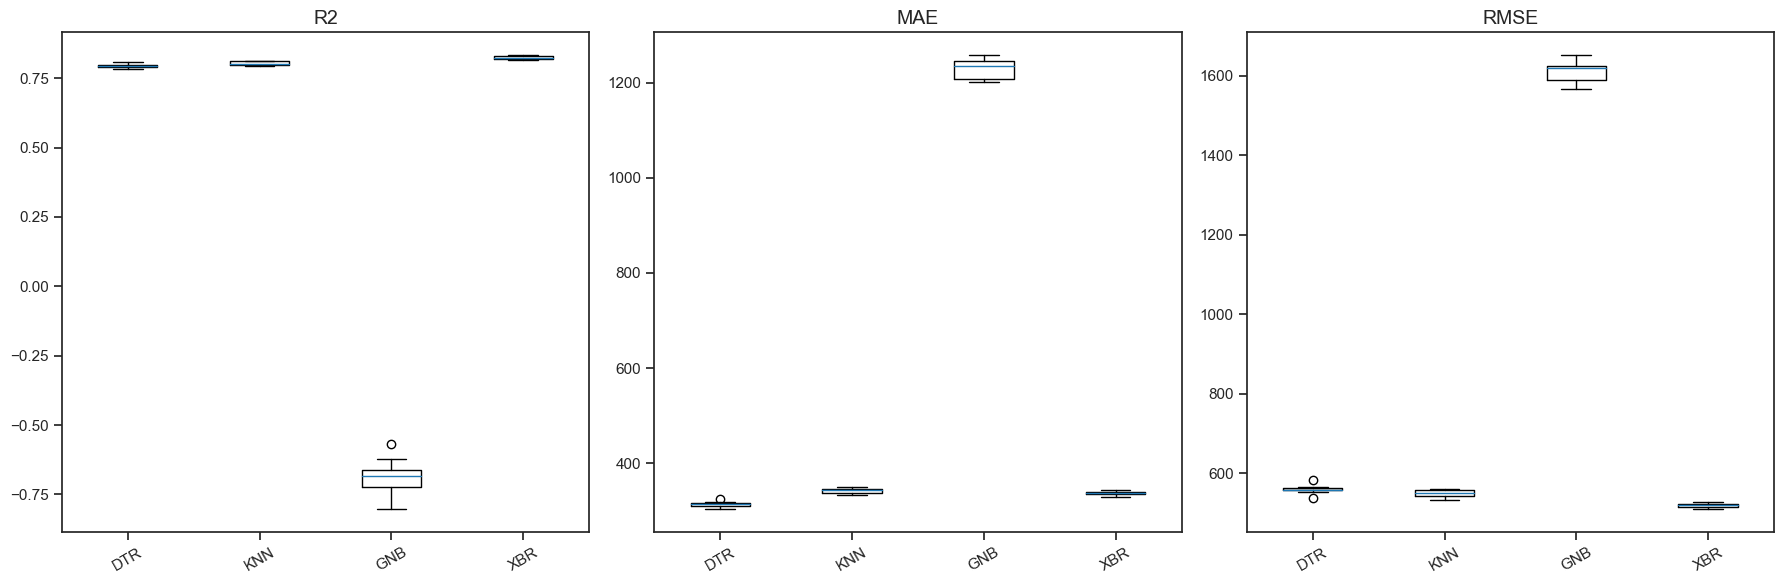

In [19]:
models_nl = []
#models_nl.append(('SVR', SVR())) I remove it as it takes way tooooo long to execure in Kaggle platform
models_nl.append(('DTR', DecisionTreeRegressor()))
models_nl.append(('KNN', KNeighborsRegressor()))
models_nl.append(('GNB', GaussianNB()))
models_nl.append(('XBR', XGBRegressor()))

model_comparison(x_train, y_train, models_nl)

### 4.1.3. Training the Model

In [20]:
model_rfr = RandomForestRegressor()
model_rfr.fit(x_train, y_train)

RandomForestRegressor()

In [21]:
y_hat = model_rfr.predict(x_test)

In [39]:
def model_results(x_test, y_test, y_hat):
    print(f'Model Score: {model_rfr.score(x_test, y_test)}')
    print('='*100)
    
    # Plotting true values with the predicted values
    plt.scatter(y_test, y_hat)
    plt.xlabel('Actual Energy Delta')
    plt.ylabel('Predicted Energy Delta')
    plt.title('Actual vs Predicted Energy Delta')
    plt.show()
    print('='*100)
    
    df_compare = pd.DataFrame(columns=['Targets', 'Predictions'])
    df_compare['Targets'] = y_test
    df_compare['Predictions'] = y_hat
    df_compare['Residuals'] = df_compare['Targets'] - df_compare['Predictions'] 
    df_compare['Difference%'] = np.absolute(df_compare['Residuals']/df_compare['Targets']*100) 
    print('The worst 10 predictions')
    print('-'*100)
    print(df_compare.sort_values('Difference%', ascending=False).head(10))
    print('='*100)
    
    # Plotting residuals
    sb.scatterplot(x=df_compare['Predictions'], y=df_compare['Residuals'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs. Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

Model Score: 0.8876072526727307


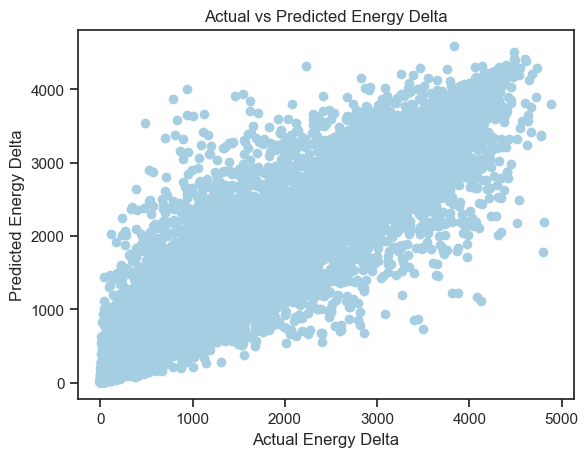

The worst 10 predictions
----------------------------------------------------------------------------------------------------
       Targets  Predictions  Residuals  Difference%
29553        2      195.080   -193.080     9654.000
32274        3      221.550   -218.550     7285.000
36359        2      129.850   -127.850     6392.500
106         15      822.490   -807.490     5383.267
67310       10      543.270   -533.270     5332.700
32679        2      106.770   -104.770     5238.500
67444       13      624.740   -611.740     4705.692
76891        2       93.750    -91.750     4587.500
67459        5      220.510   -215.510     4310.200
67445       16      630.470   -614.470     3840.438


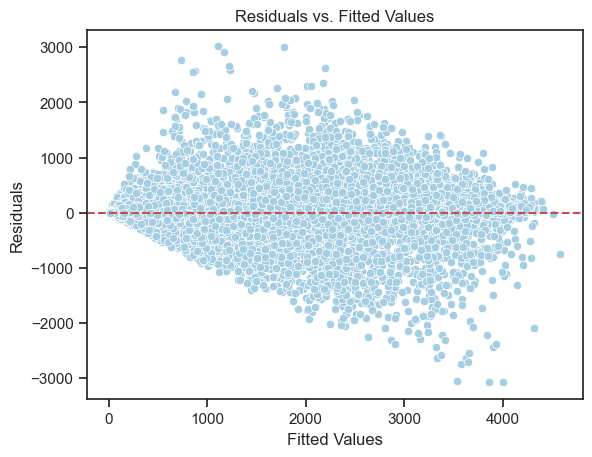

In [40]:
model_results(x_test, y_test, y_hat)

## 4.2 Exemining the Impact of 'rain_1h' and 'snow_1h' Features

In [27]:
df.columns

Index(['Energy_Delta', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
       'snow_1h', 'clouds_all', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')

In [33]:
df['rain_1h'][df['rain_1h']!=0].describe()

count   13694.000
mean        0.515
std         0.644
min         0.100
25%         0.160
50%         0.270
75%         0.600
max         7.310
Name: rain_1h, dtype: float64

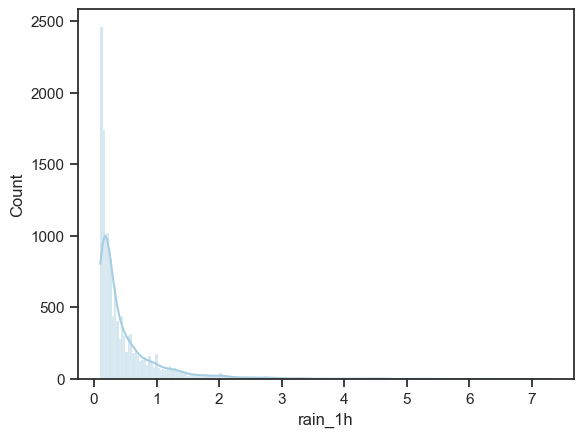

In [29]:
sb.histplot(data=df[df['rain_1h']!=0], x='rain_1h', kde=True);

<AxesSubplot: ylabel='rain_1h'>

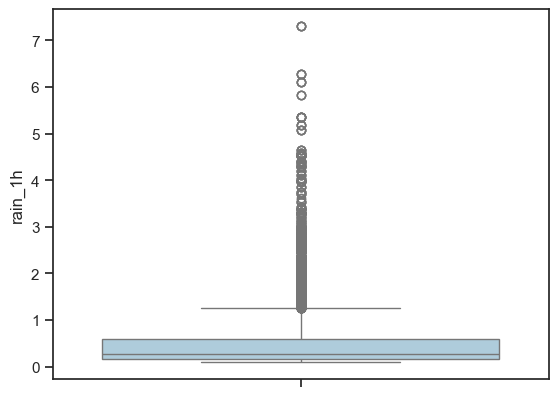

In [41]:
sb.boxplot(data=df[df['rain_1h']!=0], y='rain_1h')

In [42]:
df[df['rain_1h']>=5]

,Energy_Delta,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,SunlightTime/daylength,weather_type,hour,month
8104,33,17.200,1005,97,6.100,5.820,0.000,99,0.060,5,3,6
8105,43,17.200,1005,97,6.100,5.820,0.000,99,0.070,5,3,6
8106,85,17.200,1005,97,6.100,5.820,0.000,99,0.090,5,3,6
8107,251,17.000,1004,97,5.200,6.110,0.000,98,0.100,5,4,6
8108,295,17.000,1004,97,5.200,6.110,0.000,98,0.120,5,4,6
8109,305,17.000,1004,97,5.200,6.110,0.000,98,0.130,5,4,6
8110,281,17.000,1004,97,5.200,6.110,0.000,98,0.150,5,4,6
8111,354,17.000,1004,99,5.800,7.310,0.000,100,0.160,5,5,6
8112,730,17.000,1004,99,5.800,7.310,0.000,100,0.180,5,5,6
8113,516,17.000,1004,99,5.800,7.310,0.000,100,0.190,5,5,6


<AxesSubplot: xlabel='weather_type', ylabel='rain_1h'>

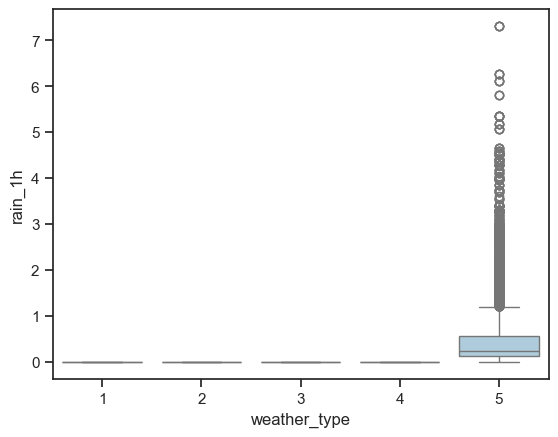

In [46]:
sb.boxplot(data=df, y='rain_1h', x='weather_type')

In [44]:
df['weather_type'].value_counts()

4    33755
2    17960
3    16199
5    14745
1    13267
Name: weather_type, dtype: int64

In [47]:
df[(df['weather_type']!=5) & (df['rain_1h']!=0)]

,Energy_Delta,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,SunlightTime/daylength,weather_type,hour,month


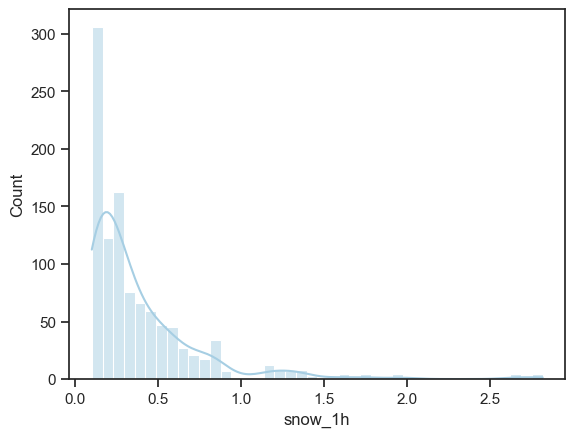

In [30]:
sb.histplot(data=df[df['snow_1h']!=0], x='snow_1h', kde=True);

<AxesSubplot: xlabel='weather_type', ylabel='snow_1h'>

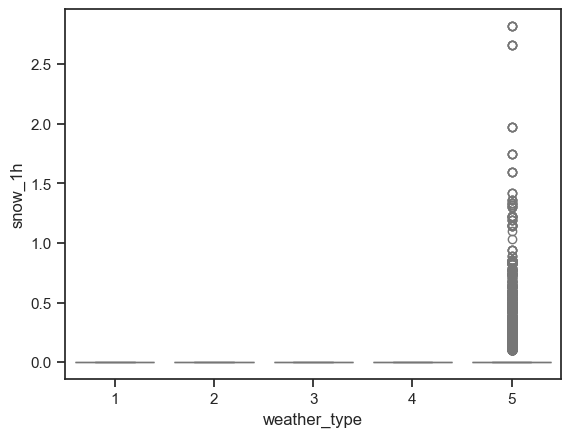

In [49]:
sb.boxplot(data=df, y='snow_1h', x='weather_type')

In [50]:
df[(df['weather_type']!=5) & (df['snow_1h']!=0)]

,Energy_Delta,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,SunlightTime/daylength,weather_type,hour,month


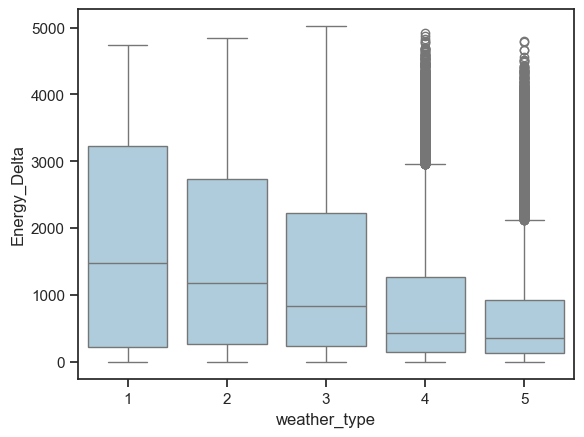

In [51]:
sb.boxplot(data=df, x='weather_type', y='Energy_Delta');

In [52]:
df_weather_type = df.drop(['rain_1h', 'snow_1h'], axis=1)
df_weather_type.to_csv('./Data/Processed/df_weather_type.csv')

In [53]:
df_weather_type.dtypes

Energy_Delta                int64
temp                      float64
pressure                    int64
humidity                    int64
wind_speed                float64
clouds_all                  int64
SunlightTime/daylength    float64
weather_type               object
hour                       object
month                      object
dtype: object

In [54]:
num_cols.remove('rain_1h')
num_cols.remove('snow_1h')

In [55]:
x_train, x_test, y_train, y_test = transform_data(df, target, num_cols[1:], cat_cols)
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (76740, 38)
x_test: (19186, 38)


### 4.2.1. Ensemble Methods

In [56]:
models_ens = []
models_ens.append(('RFR', RandomForestRegressor()))
models_ens.append(('ADR', AdaBoostRegressor()))
models_ens.append(('GBR', GradientBoostingRegressor()))

           R2 Mean  R2 STD  RMSE Mean  RMSE STD  MAE Mean  MEA STD
Algorithm                                                         
RFR          0.882   0.003    424.227     4.964   255.199    2.110
ADR          0.615   0.011    766.753    12.651   615.408   12.566
GBR          0.756   0.004    609.971     6.221   416.615    5.582


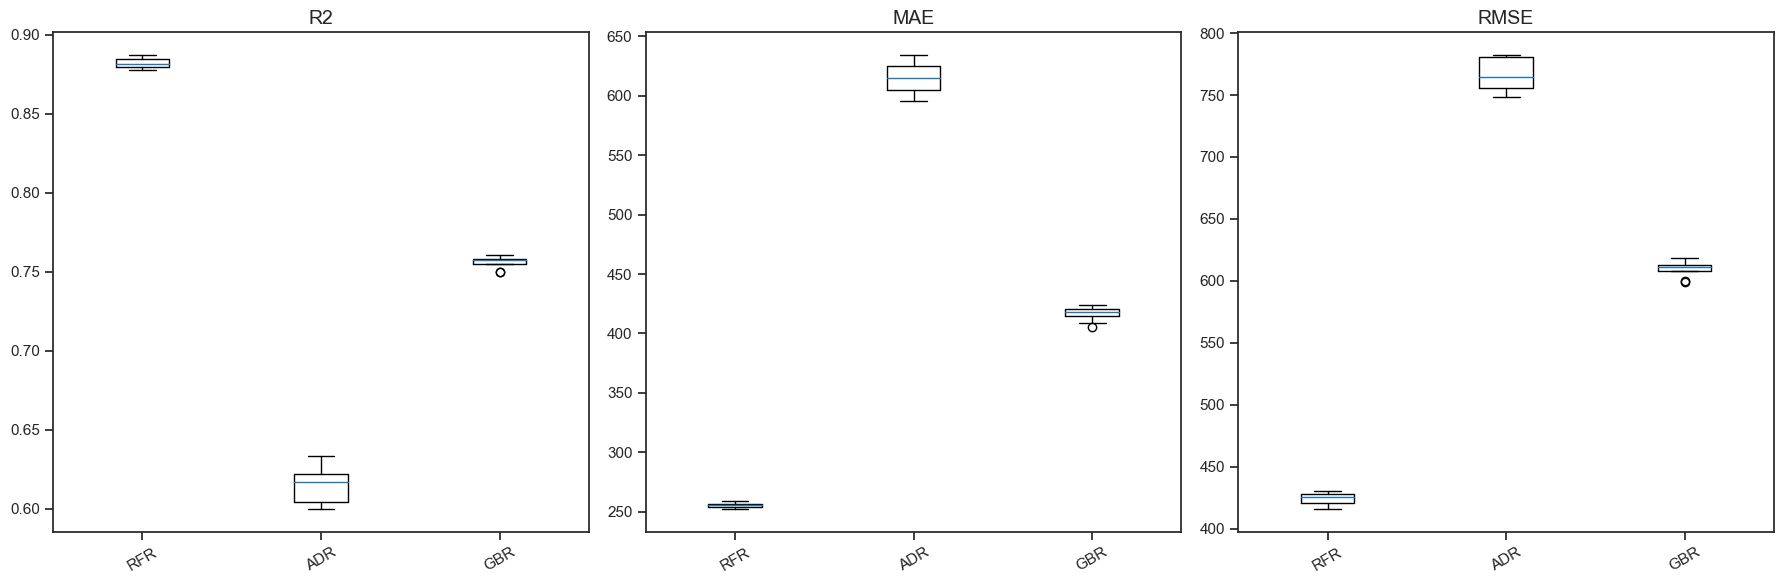

In [57]:
model_comparison(x_train, y_train, models_ens)

### 4.2.2. Non-linear Methods

           R2 Mean  R2 STD  RMSE Mean  RMSE STD  MAE Mean  MEA STD
Algorithm                                                         
DTR          0.796   0.007    557.939     9.823   313.400    5.060
KNN          0.802   0.005    549.847     6.514   343.098    3.705
GNB         -0.786   0.077   1650.544    35.086  1259.494   24.765
XBR          0.826   0.003    515.949     4.432   334.305    3.422


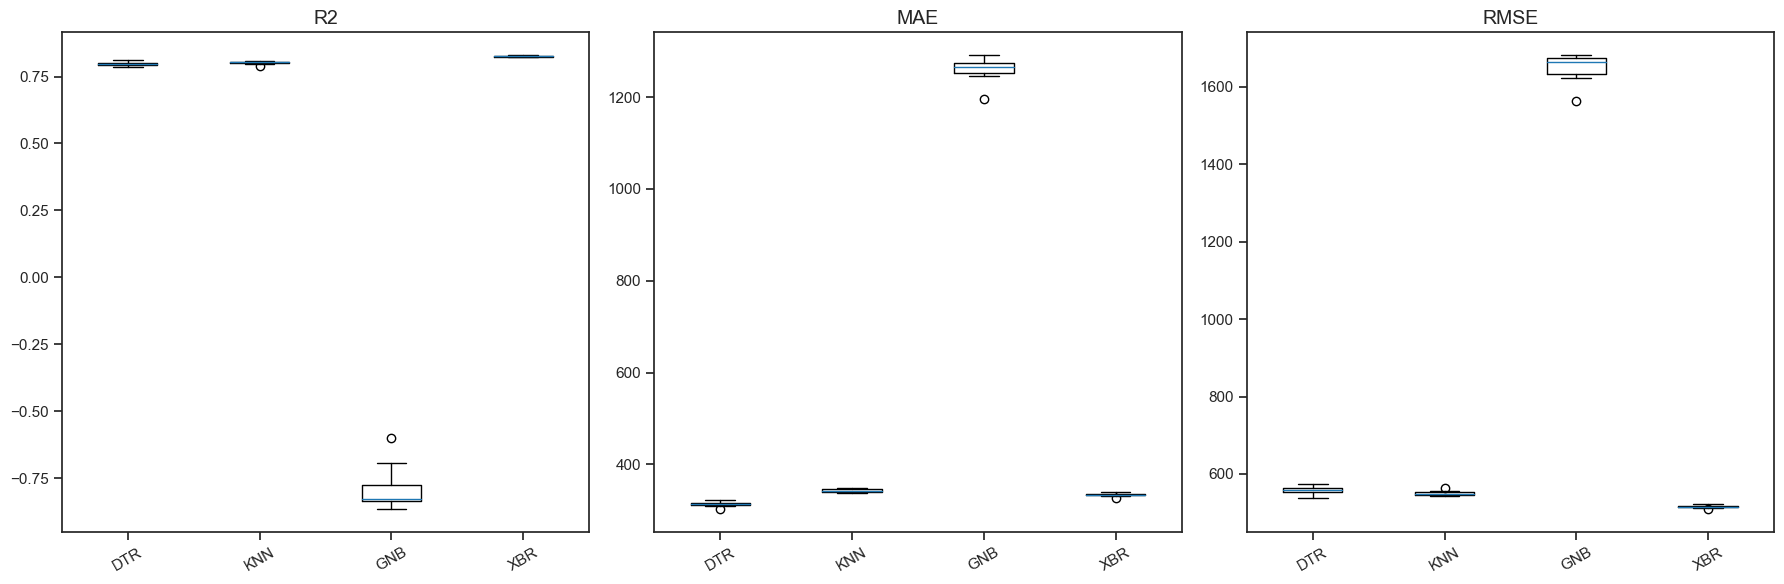

In [58]:
models_nl = []
models_nl.append(('DTR', DecisionTreeRegressor()))
models_nl.append(('KNN', KNeighborsRegressor()))
models_nl.append(('GNB', GaussianNB()))
models_nl.append(('XBR', XGBRegressor()))

model_comparison(x_train, y_train, models_nl)

### 4.2.3. Trainin the Model

Model Score: 0.8909194194724173


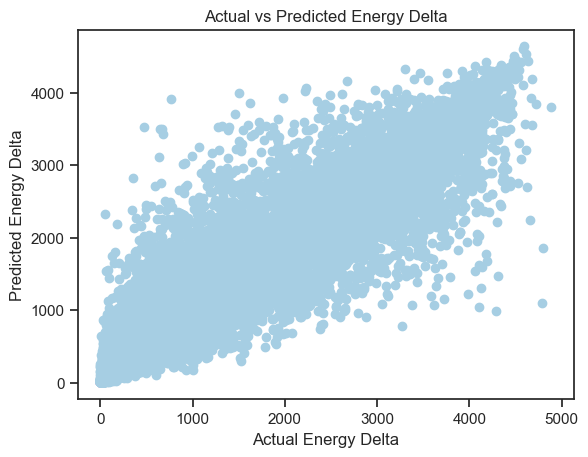

The worst 10 predictions
----------------------------------------------------------------------------------------------------
       Targets  Predictions  Residuals  Difference%
47743        1      144.340   -143.340    14334.000
93102        2      261.110   -259.110    12955.500
70654        5      642.600   -637.600    12752.000
26475        2      230.470   -228.470    11423.500
83545        2      209.500   -207.500    10375.000
36359        2      157.760   -155.760     7788.000
32274        3      212.530   -209.530     6984.333
20569        2      101.110    -99.110     4955.500
6624        48     2331.130  -2283.130     4756.521
66742        1       42.800    -41.800     4180.000


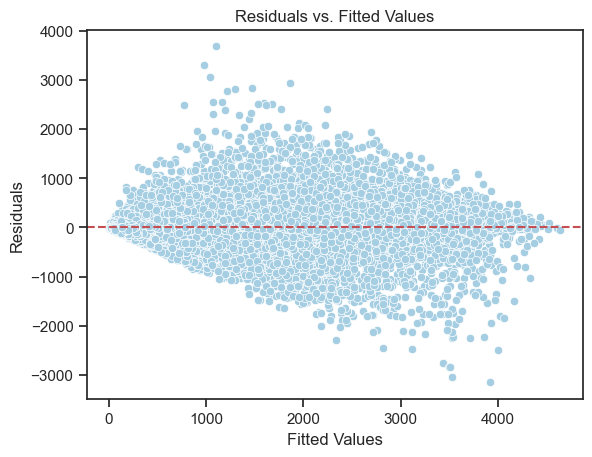

In [59]:
model_rfr = RandomForestRegressor()
model_rfr.fit(x_train, y_train)
y_hat = model_rfr.predict(x_test)
model_results(x_test, y_test, y_hat)